In [1]:
# General imports
import numpy as np
np.random.seed(42)
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import os
import yaml
import importlib.util
from resum.multi_fidelity_gaussian_process import MultiFidelityVisualizer
from resum.multi_fidelity_gaussian_process import MFGPModel

In [2]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [3]:
# Set the path to the yaml settings file here
path_to_settings = "../"
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp = config_file["path_settings"]["path_out_cnp"]
path_out_cnp  += f"/{version}"
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
path_out_mfgp  += f"/{version}"
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'

In [4]:

if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
x_labels_plot   = config_file["simulation_settings"]["theta_headers_plot"]
y_labels_plot   = config_file["simulation_settings"]["target_headers_plot"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

y_scaling = config_file["simulation_settings"]["y_scaling"]
y_scaling = 1.
# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]
x_fixed = config_file["simulation_settings"]["theta_fixed"]
parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]

# Assign costs
low_fidelity_cost = config_file["simulation_settings"]["lf_cost"]
high_fidelity_cost = config_file["simulation_settings"]["lf_cost"]

In [5]:
y_label_lf = y_label_cnp
y_label_mf = y_label_cnp
y_label_hf = y_label_sim

In [6]:
data=pd.read_csv(file_in)
data = data.drop_duplicates()

In [7]:

LF_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())**2
MF_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())**2
HF_noise=np.var(y_scaling*data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
row_h=data.index[data['fidelity'] == 1].tolist()
row_l=data.index[data['fidelity'] == 0].tolist()

x_train_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf = (y_scaling*data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_hf].to_numpy()).tolist()

x_train_mf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_mf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_mf].to_numpy().tolist()

x_train_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_lf].to_numpy().tolist()

data_dict = {"lf": [x_train_lf,y_train_lf], "mf": [x_train_mf,y_train_mf],"hf": [x_train_hf,y_train_hf]}
# Set trainings data
trainings_data = {}
for key in config_file["mfgp_settings"]["noise"]:
    trainings_data[key]= data_dict[key]

In [8]:

noise = config_file["mfgp_settings"]["noise"]
noise["lf"] = LF_noise
if "mf" in noise:
    noise["mf"] = MF_noise


In [9]:
# Path to the inequalities.py file
file_path = f"{path_to_settings}/inequalities.py"

if os.path.exists(file_path):
    spec = importlib.util.spec_from_file_location("inequalities", file_path)
    inequalities_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(inequalities_module)
    InequalityConstraints = inequalities_module.InequalityConstraints
    inequalities = InequalityConstraints()
    print("InequalityConstraints loaded successfully.")
else:
    inequalities = None

In [10]:
mf_model = MFGPModel(trainings_data, noise, normalize=False, inequality_constraints=inequalities)

In [11]:
mf_model.build_model(10)

 /global/cfs/projectdirs/katrin/users/aschuetz/software/conda_envs/resum/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -2772.2449851641372
Optimization restart 2/10, f = -285.86293296486343
Optimization restart 3/10, f = -2772.2449843890026
Optimization restart 4/10, f = -285.8629330345962
Optimization restart 5/10, f = -1358.6986171829467
Optimization restart 6/10, f = -285.8629330346652
Optimization restart 7/10, f = -2772.244985141711
Optimization restart 8/10, f = -2772.244985168053
Optimization restart 9/10, f = -285.86293302029526
Optimization restart 10/10, f = -285.8629324765763


In [12]:
mf_model.model.gpy_model

gp.,value,constraints,priors
multifidelity.RBF_rho_0.variance,0.022327403252983144,+ve,
multifidelity.RBF_rho_0.lengthscale,529.7822593722207,,
multifidelity.RBF_delta_0.variance,8.775356709272239e-05,+ve,
multifidelity.RBF_delta_0.lengthscale,0.013670062648874291,+ve,
multifidelity.scale,0.006078770544044307,,
mixed_noise.Gaussian_noise.variance,0.0004732848111120999,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,0.0,+ve fixed,


In [13]:
%%capture
leg_label = []
ncol=3
nrow=int(np.ceil(len(x_labels)/ncol))
fig2,_  = plt.subplots(nrow, ncol, figsize=(15, 5), constrained_layout=True)
fig4,_  = plt.subplots(int(np.ceil(len(x_labels)/1)), 1, figsize=(5, 12), constrained_layout=True)



In [14]:
mf_vis = MultiFidelityVisualizer(mf_model,parameters,x_fixed)

In [15]:

sample=0
active_learning = False
add_new_sample=True

while ( sample <= data['iteration'].max()):
    print('Sample #', sample)
    if sample > 0:    
        x_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_sim].to_numpy().tolist()
        print(f"Adding {x_train_hf_sim}")   
        x_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_cnp].to_numpy().tolist()

        x_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][ y_label_cnp].to_numpy().tolist()
        trainings_data_new = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
        mf_model.set_data(trainings_data_new)

    # run the model drawing
    fig1, ax = plt.subplots(2, 3,figsize=(15, 5),constrained_layout=True)
    fig1 = mf_vis.draw_model_projections(fig1, outname=f"{path_out_mfgp}/resum_{version}_model_proj.png")
    fig2 = mf_vis.draw_model_projections(fig2, outname=f"{path_out_mfgp}/resum_{version}_model_proj_updated.png")

    # find the next data point
    if sample == data['iteration'].max() and active_learning==True:
        x_next_sample, us_acquisition = mf_model.max_acquisition_integrated_variance_reduction(parameters)
        print(f'next suggested point to simulated is at: {x_next_sample}')
        fig4 = mf_vis.draw_acquisition_func(fig4, us_acquisition, np.array(x_next_sample),outname=f"{path_out_mfgp}/resum_{version}_model_acq.png")
        
    sample+=1


Sample # 0


<IPython.core.display.Javascript object>

In [16]:
fig3,_ = mf_vis.model_validation(trainings_data, outname=f"{path_out_mfgp}/resum_{version}_model.png")

<IPython.core.display.Javascript object>

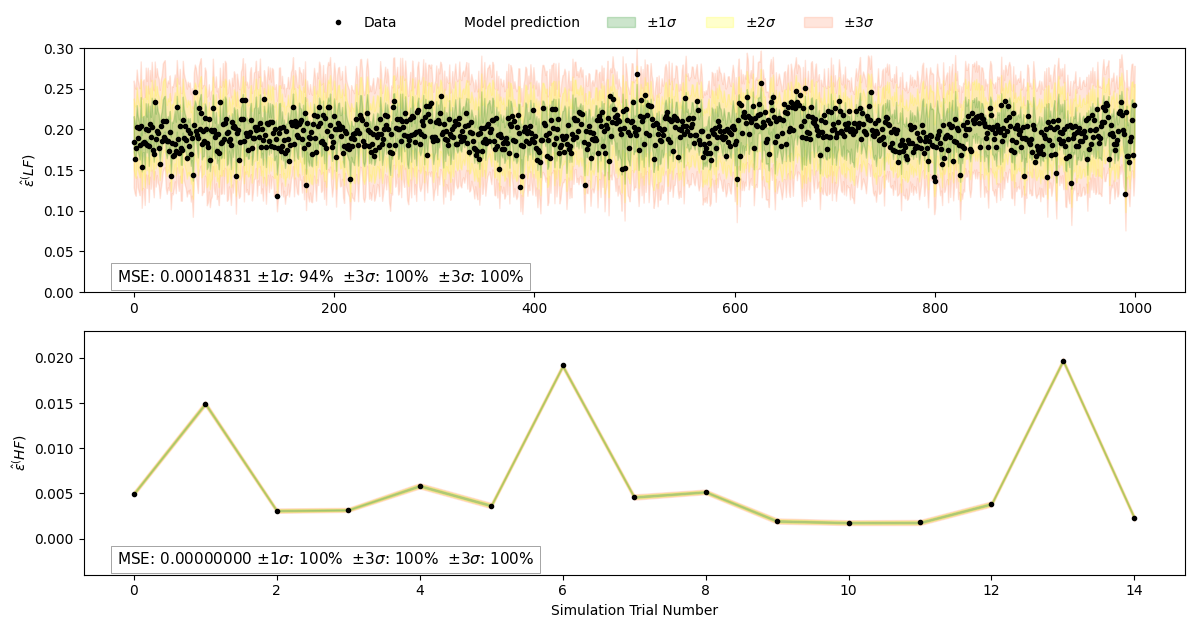

In [17]:
axes_list = fig3.axes
axes_list[0].set_ylabel(f"{y_labels_plot}"+"$^({LF})$")
axes_list[0].set_ylim(0.0,0.3)
axes_list[1].set_ylim(-0.004,0.023)
axes_list[1].set_ylabel(f"{y_labels_plot}"+"$^({HF})$")
fig3.savefig(f"{path_out_mfgp}/resum_{version}_model.png",dpi=300, bbox_inches='tight')
fig3

In [18]:
x_test_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==-2)][x_labels].to_numpy().tolist()
y_test_lf = (y_scaling*data.loc[(data['fidelity']==0.) & (data['iteration']==-2)][y_label_lf].to_numpy()).tolist()
x_test_mf = data.loc[(data['fidelity']==1.) & (data['iteration']==-2)][x_labels].to_numpy().tolist()
y_test_mf = (y_scaling*data.loc[(data['fidelity']==1.) & (data['iteration']==-2)][y_label_mf].to_numpy()).tolist()
x_test_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==-2)][x_labels].to_numpy().tolist()
y_test_hf = (y_scaling*data.loc[(data['fidelity']==1.) & (data['iteration']==-2)][y_label_hf].to_numpy()).tolist()

test_data_dict = {"lf": [x_test_lf,y_test_lf], "hf": [x_test_mf,y_test_mf],"hf": [x_test_hf,y_test_hf]}
# Set trainings data
test_data = {}
for key in config_file["mfgp_settings"]["noise"]:
    test_data[key]= test_data_dict[key]

<IPython.core.display.Javascript object>

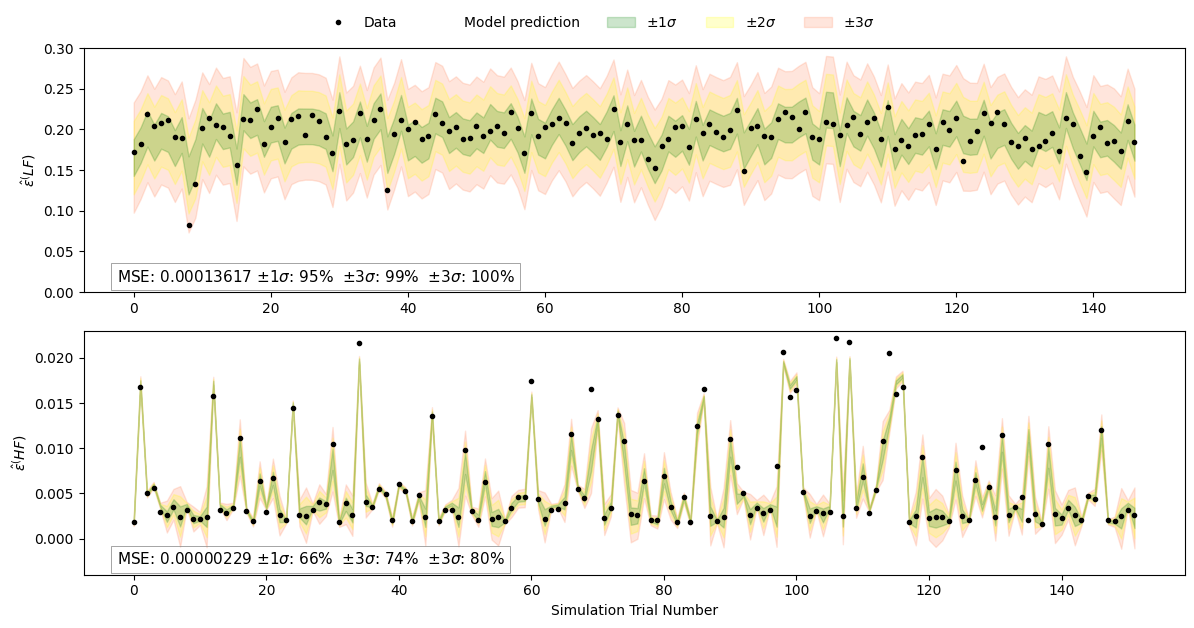

In [19]:
fig5, validation  = mf_vis.model_validation(test_data,outname=f"{path_out_mfgp}/resum_{version}_validation.png")
axes_list = fig5.axes
axes_list[0].set_ylabel(f"{y_labels_plot}"+"$^({LF})$")
axes_list[0].set_ylim(0.0,0.3)
axes_list[1].set_ylim(-0.004,0.023)
axes_list[1].set_ylabel(f"{y_labels_plot}"+"$^({HF})$")
fig5.savefig(f"{path_out_mfgp}/resum_{version}_validation.png",dpi=300, bbox_inches='tight')
fig5

In [20]:

print(validation)

[65.78947368421053, 73.68421052631578, 79.60526315789474, 2.2852759832025965e-06]


In [ ]:

fig6 = mf_vis.plot_marginalized(None, None, grid_steps=50,smoothing=2, outname=f"{path_out_mfgp}/resum_{version}_marginalized.png")
axes_list = fig6.axes
for i,l in enumerate(x_labels_plot):
    axes_list[len(x_labels_plot)+i].set_xlabel(l)
fig6.savefig(f"{path_out_mfgp}/mfgp_{version}_marginalized.png",dpi=300, bbox_inches='tight')
fig6
fig6.savefig(f"{path_out_mfgp}/resum_{version}_marginalized.png",dpi=300, bbox_inches='tight')
fig6
